<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 1

</h4>

# Personal Data

In [43]:
# Set your student number
student_number = 99102189
Name = 'Mohammad'
Last_Name = 'Mohammad Beigi'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch.

In [44]:
!pip install numpy
!pip install matplotlib
!pip install torchvision
!pip install torch

## Importing Libraries

In [45]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt
from typing import Dict

## Datasets and Dataloaders

Here, we download and load the train and test `FashionMNIST` dataset with the desired transforms. Then, we define the dataloaders for `train` and `test`.

In [46]:
train_set = FashionMNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
test_set = FashionMNIST(root='.', train=False, download=True, transform=transforms.ToTensor())


Here you have to calculate the number of classes amd input dimention of the first layer (how many pixels does each image have?).

In [47]:
# Calculate number of classes in the dataset
num_classes = len(train_set.classes)

# Calculate input dimensions (assuming images are square)
input_dim = train_set[0][0].numel()  # Number of elements in the first image tensor

In [48]:
train_loader = DataLoader(train_set, 64, shuffle=True)
test_loader = DataLoader(test_set, 64, shuffle=True)

## Visualization

Visualize 1 random image from each class by using `plt.subplots`

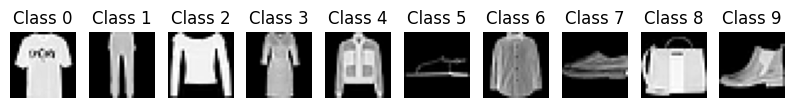

In [49]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_random_images(dataset, num_classes):
    fig, axes = plt.subplots(1, num_classes, figsize=(10, 2))
    class_images = {}

    # Gather one image per class
    while len(class_images) < num_classes:
        index = np.random.randint(0, len(dataset))
        image, label = dataset[index]
        if label not in class_images:
            class_images[label] = image

    # Plot the images
    for i, (label, image) in enumerate(sorted(class_images.items())):
        ax = axes[i]
        ax.imshow(image.squeeze(), cmap='gray')
        ax.set_title(f'Class {label}')
        ax.axis('off')

    plt.show()

visualize_random_images(train_set, 10)  # There are 10 classes in FashionMNIST


## Initializing model's parameters

In this part, we create the model and initialize its parameters and store the values of these parameters in the variable `parameters` which is a dictionary including the weigths and biases of each layer.

In [50]:
def add_linear_layer(parameters: dict, shape, device, i=None):
    """
    This function adds parameters of a linear unit of shape `shape` to the `parameters` dictionary.
    """
    n_in, n_out = shape
    with torch.no_grad():
        w = torch.zeros(*shape, device=device)
        # kaiming initialization for ReLU activations:
        bound = 1 / np.sqrt(n_in).item()
        w.uniform_(-bound, bound)
        b = torch.zeros(n_out, device=device)  # no need to (1, n_out). it will broadcast itself.
    w.requires_grad = True
    b.requires_grad = True
    # `i` is used to give numbers to parameter names
    parameters.update({f'w{i}': w, f'b{i}': b})

Now we define our neural network with the given layers and add the weights and biases to the dictionary `parameters`. **You are allowed to modify the values of the layers**.

In [51]:
# input_dim : input dimention of the first layer, which you have calculated before.
layers = [
    (input_dim, 512),
    (512, 256),
    (256, 128),
    (128, 64),
    (64, num_classes)
]
num_layers = len(layers)
parameters = {}

# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# adding the parameters to the dictionary
for i, shape in enumerate(layers):
    add_linear_layer(parameters, shape, device, i)

parameters.keys()

dict_keys(['w0', 'b0', 'w1', 'b1', 'w2', 'b2', 'w3', 'b3', 'w4', 'b4'])

## Defining the required functions

In this section, we should define the required functions. For each of these functions, the inputs and the desired outputs are given and you should write all or part of the function. **You are not allowed to use the activation functions and the loss functions implemented in torch**.

Computing affine and relu outputs:

In [52]:
def affine_forward(x, w, b):
    return torch.matmul(x, w) + b


def relu(x):
    return torch.maximum(x, torch.tensor(0.0, device=x.device))


Function `model` returns output of the whole model for the input `x` using the parameters:

In [53]:
def model(x: torch.Tensor, parameters, num_layers=num_layers):
    B = x.shape[0]  # number of batches
    x = x.view(B, -1)  # Flatten the input

    # Iterate over each layer and apply the affine transformation and ReLU
    for i in range(num_layers):
        w = parameters[f'w{i}']
        b = parameters[f'b{i}']
        x = affine_forward(x, w, b)  # Apply affine transformation
        if i < num_layers - 1:  # Apply ReLU activation to all but the last layer
            x = relu(x)

    return x


Implementing cross entropy loss:

In [54]:
import torch

def cross_entropy_loss(scores, y):
    n = len(y)  # Number of samples
    # Convert scores to probabilities using softmax
    probabilities = torch.exp(scores) / torch.exp(scores).sum(dim=1, keepdim=True)
    # Gather the probabilities corresponding to the true classes
    correct_probabilities = probabilities[range(n), y]
    # Compute the negative log of these probabilities
    loss = -torch.log(correct_probabilities).mean()
    return loss


Implementing a function for optimizing paramters and a function to zeroing out their gradients:

In [55]:
def sgd_optimizer(parameters: Dict[str, torch.Tensor], learning_rate=0.001):
    # Update parameters
    for param in parameters.values():
        if param.grad is not None:  # Only try to update parameters that have gradients
            param.data -= learning_rate * param.grad.data

    # Zero the gradients after updating
    for param in parameters.values():
        if param.grad is not None:
            param.grad = None


Training functions:

In [56]:
def accuracy(y_pred: np.ndarray, y_true: np.ndarray):
    # Calculate the number of correct predictions
    correct_predictions = np.sum(y_pred == y_true)
    # Calculate the accuracy: correct predictions / total number of data points
    acc = correct_predictions / len(y_true)
    return acc


def train(train_loader, learning_rate=0.001, epoch=None):
    train_loss = 0
    N_train = len(train_loader.dataset)

    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculating the accuracy later
    Y = []
    Y_pred = []

    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)

        # 1- Calculate the output of the model to the given input batch
        p = model(x, parameters)

        # 2- Calculate the loss based on the model output
        loss = cross_entropy_loss(p, y)
        train_loss += loss.item() * y.size(0)  # Multiply by batch size for proper averaging later

        # 3- Update the gradients using backward method
        loss.backward()

        # 4- Optimize the model parameters using the sgd_optimizer function defined previously
        sgd_optimizer(parameters, learning_rate)

        # Print the train loss (Show the epoch and batch as well)
        print(f'Epoch: {epoch}, Batch: {i}, Batch Loss: {loss.item()}')

        # Store labels and predictions for accuracy calculation
        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())

    # Finalize loss and calculate accuracy
    train_loss /= N_train  # Average loss over all samples
    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of train set: {acc}')

    return train_loss, acc


def validate(loader, epoch=None, set_name=None):
    total_loss = 0
    N = len(loader.dataset)

    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculating the accuracy later
    Y = []
    Y_pred = []

    # Make sure to iterate over the correct loader, which should be passed as an argument
    for i, (x, y) in enumerate(loader):
        x = x.to(device)
        y = y.to(device)

        # 1- Calculate the model output
        p = model(x, parameters)

        # 2- Calculate the loss using the model output
        loss = cross_entropy_loss(p, y)
        total_loss += loss.item() * y.size(0)  # Multiply by batch size for proper averaging later

        # Print the loss for each batch and epoch
        print(f'Epoch: {epoch}, Batch: {i}, {set_name} Batch Loss: {loss.item()}')

        # Store labels and predictions for accuracy calculation
        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())

    # Calculate total loss and accuracy
    total_loss /= N  # Average loss over all samples
    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of {set_name} set: {acc}')

    return total_loss, acc, Y_pred

In [57]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [58]:
import matplotlib.pyplot as plt

def train_model(dataloaders, num_epochs, learning_rate=0.001, model_name='pytorch_model'):
    train_loader, test_loader = dataloaders

    # Lists to store losses and accuracies
    global train_losses, test_losses, train_accuracies, test_accuracies

    for epoch in range(num_epochs):
        # Training phase
        train_loss, train_acc = train(train_loader, learning_rate, epoch)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation phase
        test_loss, test_acc, Y_pred = validate(test_loader, epoch, set_name='test')
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Print epoch summary
        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
    return Y_pred

    # Plotting loss history
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting accuracy history
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title('Accuracy History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [59]:
Y_pred = train_model([train_loader, test_loader], num_epochs=25, learning_rate=0.005)

Streaming output truncated to the last 5000 lines.
Epoch: 20, Batch: 490, Batch Loss: 0.3787146806716919
Epoch: 20, Batch: 491, Batch Loss: 0.6821416616439819
Epoch: 20, Batch: 492, Batch Loss: 0.23397426307201385
Epoch: 20, Batch: 493, Batch Loss: 0.4061078429222107
Epoch: 20, Batch: 494, Batch Loss: 0.5024861693382263
Epoch: 20, Batch: 495, Batch Loss: 0.3040231466293335
Epoch: 20, Batch: 496, Batch Loss: 0.6456047892570496
Epoch: 20, Batch: 497, Batch Loss: 0.5842409729957581
Epoch: 20, Batch: 498, Batch Loss: 0.5186441540718079
Epoch: 20, Batch: 499, Batch Loss: 0.43440210819244385
Epoch: 20, Batch: 500, Batch Loss: 0.27056336402893066
Epoch: 20, Batch: 501, Batch Loss: 0.4180242121219635
Epoch: 20, Batch: 502, Batch Loss: 0.42897316813468933
Epoch: 20, Batch: 503, Batch Loss: 0.274751216173172
Epoch: 20, Batch: 504, Batch Loss: 0.3741123080253601
Epoch: 20, Batch: 505, Batch Loss: 0.420360803604126
Epoch: 20, Batch: 506, Batch Loss: 0.44928795099258423
Epoch: 20, Batch: 507, Batch

In [60]:
print(f'Final test accuracy: {test_accuracies[-1]}')

Final test accuracy: 0.8433


## Visualization of the labels and predictions

In this section, you should visual one image from each class and show both the actual label and the predicted label for that image.

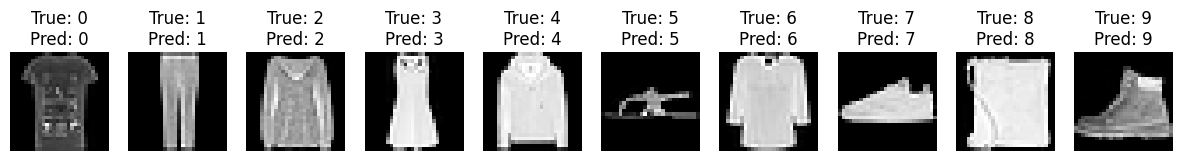

In [61]:
import matplotlib.pyplot as plt

def visualize_labels_and_predictions(dataset, predictions):
    num_classes = 10  # Assuming FashionMNIST or a similar dataset with 10 classes
    fig, axes = plt.subplots(1, num_classes, figsize=(15, 2))
    class_images = {}

    # Collect one correctly predicted image for each class
    for idx in range(len(dataset)):
        image, true_label = dataset[idx][0], dataset[idx][1]
        predicted_label = predictions[idx]
        if true_label not in class_images and true_label == predicted_label:
            class_images[true_label] = (image, predicted_label)

        if len(class_images) == num_classes:
            break

    # Plot the images
    for label in range(num_classes):
        ax = axes[label]
        image, predicted_label = class_images[label]
        ax.imshow(image.squeeze(), cmap='gray')
        ax.set_title(f'True: {label}\nPred: {predicted_label}')
        ax.axis('off')

    plt.show()
visualize_labels_and_predictions(test_set, Y_pred)